In [116]:
from pathlib import Path
import pandas as pd

def load_seed_comparisons(root_dir: str) -> dict[str, pd.DataFrame]:
    """Return DataFrames keyed by seed folder names (e.g., seed_1)."""
    root = Path(root_dir)
    data = {}
    print(len(sorted(root.glob("seed_*"))))
    for seed_dir in sorted(root.glob("seed_*")):
        if not seed_dir.is_dir():
            print(seed_dir)
            continue
        csv_path = seed_dir / f"{seed_dir.name}_lnz_comparison.csv"
        if not csv_path.is_file():
            print(seed_dir)
            continue  # or raise FileNotFoundError(csv_path)
        # print(seed_dir.name)
        data[seed_dir.name] = pd.read_csv(csv_path)
    return data




In [117]:
comparisons = load_seed_comparisons(
    "/fred/oz303/ezahraoui/github/fast_pp/outdir"
)
seed1_df = comparisons["seed_1"]
comparisons

99
/fred/oz303/ezahraoui/github/fast_pp/outdir/seed_10
/fred/oz303/ezahraoui/github/fast_pp/outdir/seed_23
/fred/oz303/ezahraoui/github/fast_pp/outdir/seed_24
/fred/oz303/ezahraoui/github/fast_pp/outdir/seed_35
/fred/oz303/ezahraoui/github/fast_pp/outdir/seed_42


{'seed_1':            method           lnz   lnz_err
 0         dynesty -15941.208073  0.091930
 1            mcmc -15941.004256  0.117886
 2  dynesty_morphz -15941.237147  0.161922
 3     mcmc_morphz -15941.162361  0.174178,
 'seed_11':            method           lnz   lnz_err
 0         dynesty -16181.055183  0.099449
 1            mcmc -16179.716625  0.124355
 2  dynesty_morphz -16180.850429  0.232753
 3     mcmc_morphz -16180.707901  0.237450,
 'seed_12':            method           lnz   lnz_err
 0         dynesty -16303.593966  0.110125
 1            mcmc -16302.616260  0.135760
 2  dynesty_morphz -16303.491014  0.562917
 3     mcmc_morphz -16303.057403  0.659613,
 'seed_13':            method           lnz   lnz_err
 0         dynesty -16399.591357  0.110167
 1            mcmc -16398.747001  0.118047
 2  dynesty_morphz -16399.886718  0.270050
 3     mcmc_morphz -16399.566341  0.289388,
 'seed_14':            method           lnz   lnz_err
 0         dynesty -16178.888337  0.108

In [118]:
len(comparisons.keys())

94

94


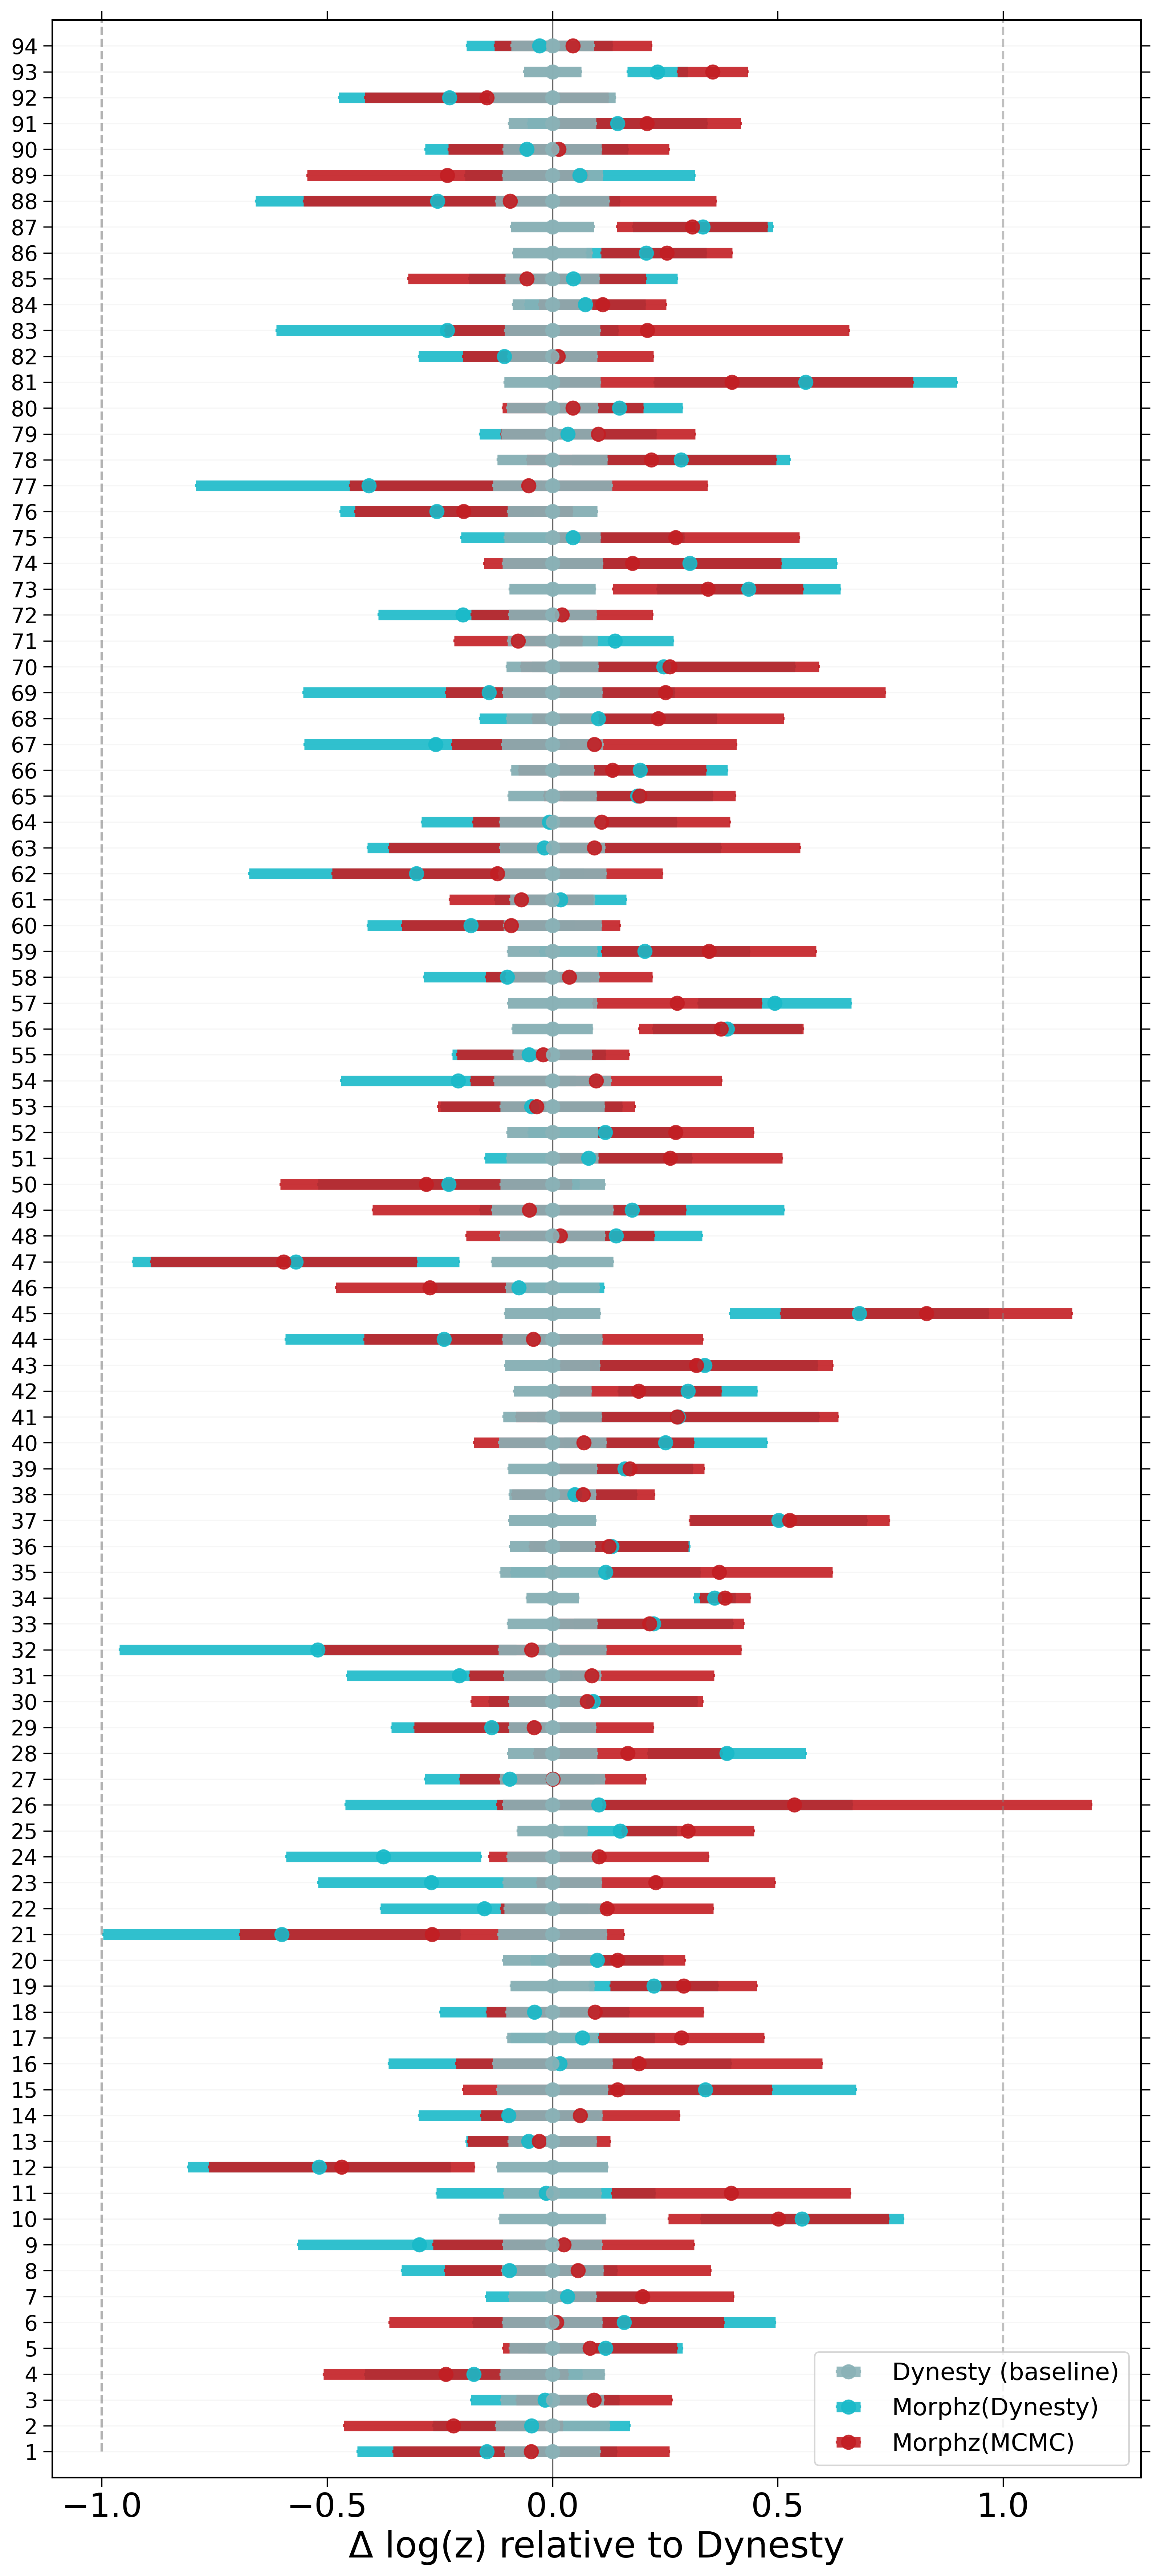

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# --- global style (adjust once, reuse everywhere) ---
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.size": 18,
    "axes.labelsize": 24,
    "axes.titlesize": 22,
    "xtick.labelsize": 22,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "axes.linewidth": 1.0,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
})
def plot_delta_lnz_spaghetti(
    results_by_seed,
    baseline='dynesty',
    methods=('dynesty', 'mcmc', 'dynesty_morphz', 'mcmc_morphz'),
    sample=None,
    propagate_baseline_error=False,
    colors=None,
    random_state=None,
):
    """
    results_by_seed: dict[str -> pd.DataFrame] with columns ['method','lnz','lnz_err']
    baseline: method name to anchor at x=0
    methods: order to plot
    sample: optional int to subsample seeds
    propagate_baseline_error: if True, xerr for non-baseline methods is
      sqrt(err_method^2 + err_baseline^2). If False (default), uses each method's own err.
    colors: optional dict to override colors by method
    """

    # choose seeds (optional subsample)
    seeds = list(results_by_seed.keys())
    if sample is not None and sample < len(seeds):
        rng = np.random.default_rng(random_state)
        seeds = list(rng.choice(seeds, size=sample, replace=False))

    # build arrays aligned by methods
    lnz_list, err_list, kept = [], [], []
    needed = set(methods)
    for s in seeds:
        df = results_by_seed[s]
        if not needed.issubset(set(df['method'])):
            continue  # skip seeds missing a method
        row = df.set_index('method').loc[list(methods)]
        lnz_list.append(row['lnz'].to_numpy())
        err_list.append(row['lnz_err'].to_numpy())
        kept.append(s)

    if not kept:
        raise ValueError("No seeds contain all requested methods.")

    lnz = np.asarray(lnz_list)  # (n_seeds, M)
    err = np.asarray(err_list)
    seeds = kept

    base_idx = methods.index(baseline)
    delta = lnz - lnz[:, [base_idx]]  # broadcast: baseline -> 0

    # choose error model for delta
    if propagate_baseline_error:
        rel_err = np.sqrt(err**2 + err[:, [base_idx]]**2)
        rel_err[:, base_idx] = err[:, base_idx]
    else:
        rel_err = err

    # sort by baseline lnz (original, not delta) to reduce crossings
    order = np.argsort(lnz[:, base_idx])
    seeds = [seeds[i] for i in order]
    delta = delta[order]
    rel_err = rel_err[order]
    lnz = lnz[order]

    # colors (matching the image vibe)
    default_colors = {
        'dynesty': "#8ab2b7",        # green/teal (baseline)
        'mcmc': "#f8474a",           # blue
        'dynesty_morphz': "#19bac9", # yellow/amber
        'mcmc_morphz': "#c31e23",    # orange
    }
    

    
    if colors:
        default_colors.update(colors)

    fig, ax = plt.subplots(figsize=(11, 24))
    y = np.arange(len(seeds))
    labes = [
        'Dynesty',        
        'SS(MCMC)',      
        'Morphz(Dynesty)', 
        'Morphz(MCMC)',   ]
    # plot points + error bars
    for j, m in enumerate(methods):
        if j==1 :
            continue
        ax.errorbar(
            delta[:, j], y, xerr=rel_err[:, j],
            fmt='o', ms=9, capsize=1, elinewidth=7,
            color=default_colors.get(m),
            alpha=0.9,
            label=f"{labes[j]} (baseline)" if j == base_idx else labes[j]
        )
    ax.errorbar(
        delta[:, 0], y, xerr=rel_err[:, 0],
        fmt='o', ms=8, capsize=1, elinewidth=7,
        color=default_colors.get('dynesty'),
        alpha=0.9,
    )
    ax.vlines(x=1,ymin=0,ymax=94,linestyles='dashed',alpha=0.5,colors="grey")
    ax.vlines(x=-1,ymin=0,ymax=94,linestyles='dashed',alpha=0.6,colors="grey")

    # connect methods within each seed (light spaghetti lines)
    # for k in range(len(seeds)):
        
    #     ax.plot(delta[k, :], [y[k]] * len(methods), alpha=0.2, color='0.3')
    print(len(seeds))
    ax.legend( loc='lower right',frameon=True)
    ax.axvline(0.0, color='k', lw=0.8, alpha=0.6)
    ax.set_yticks(np.arange(0,len(seeds)))
    ax.set_yticklabels(np.arange(1,len(seeds)+1))
    ax.set_xlabel('Δ log(z) relative to Dynesty')
    # ax.set_xlim([-6,6])
    ax.set_ylim([-1,94])

    ax.grid(axis='y',alpha=0.1)
    # ax.set_title('Per-seed Δlog(z) ±1σ by method (dynesty baseline)')
    fig.tight_layout()
    return fig, ax

# comparisons = load_seed_comparisons(root_dir)
# sorted_d = dict(sorted(comparisons.items(), reverse=False))
fig, ax = plot_delta_lnz_spaghetti(comparisons)
# If you prefer propagated errors for deltas:
# fig, ax = plot_delta_lnz_spaghetti(results_by_seed, propagate_baseline_error=True)
plt.show()